In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/home/briggsc1-erau.edu/Downloads/housing.csv')

In [3]:
df.head(3)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY

In [4]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [5]:
df = df[['latitude', 'longitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity']]

In [6]:
df.describe()

latitude     longitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean      35.631861   -119.569704           28.639486   2635.763081   
std        2.135952      2.003532           12.585558   2181.615252   
min       32.540000   -124.350000            1.000000      2.000000   
25%       33.930000   -121.800000           18.000000   1447.750000   
50%       34.260000   -118.490000           29.000000   2127.000000   
75%       37.710000   -118.010000           37.000000   3148.000000   
max       41.950000   -114.310000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [7]:
# let's model median_house_value as our target variable
# I'll pick these six features
# I don't think lat and long will be useful for a linear model,
# and I will omit the string column ocean_proximity
features = ['housing_median_age', 'total_rooms','total_bedrooms',
            'population', 'households', 'median_income']
target = ['median_house_value']

In [8]:
# drop columns we won't use
df = df[features+target]

In [9]:
# drop rows with missing data in one of the remaining columns
df = df.dropna()

In [10]:
# let's do a train-val-test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df[features],
                                                 df[target],
                                                 test_size = 0.4,
                                                 random_state = 0)

In [11]:
x_val,x_test,y_val,y_test = train_test_split(x_test,
                                             y_test,
                                             test_size = 0.5,
                                             random_state = 0)

In [12]:
len(x_train)/len(x_test)

2.9995106435037924

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
lr = LinearRegression()

In [15]:
lr.fit(x_train,y_train)
lr.score(x_val,y_val)

0.5614677159523239

In [16]:
# let's look at the coefficients
for _ in zip(features,lr.coef_[0]):
    print(_[0],_[1])


housing_median_age 1866.0512948368803
total_rooms -18.60442150988637
total_bedrooms 98.40287632209309
population -32.802336157874926
households 113.49421027982227
median_income 47133.06363115724


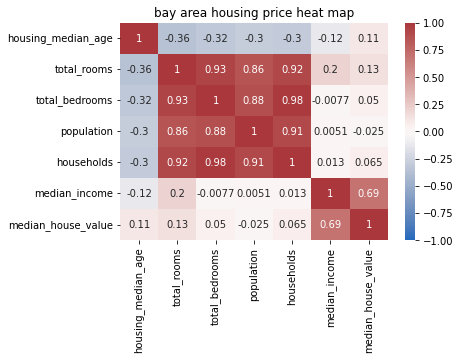

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax = plt.subplots()
ax = sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap="vlag",annot = True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_title('bay area housing price heat map');

In [24]:
from itertools import combinations

In [31]:
coef_dct = dict(zip(features,[[],[],[],[],[],[]]))

In [33]:
for i in range(1,len(features)+1):
    for feature_subset in combinations(features,i):
        feature_subset = list(feature_subset)
        df_tmp = df[feature_subset+target]
        df_tmp = df_tmp.dropna()
        x_train,x_test,y_train,y_test = train_test_split(df_tmp[feature_subset],
                                                         df_tmp[target],
                                                         test_size = 0.4,
                                                         random_state = 0)
        x_val,x_test,y_val,y_test = train_test_split(x_test,
                                                     y_test,
                                                     test_size = 0.5,
                                                     random_state = 0)
        lr = LinearRegression()
        lr.fit(x_train,y_train)
        lr.score(x_val,y_val)
        for item in zip(feature_subset, lr.coef_[0]):
            coef_dct[item[0]].append(item[1])

In [36]:
df_coef = pd.DataFrame(coef_dct)

In [38]:
features

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

<AxesSubplot: >

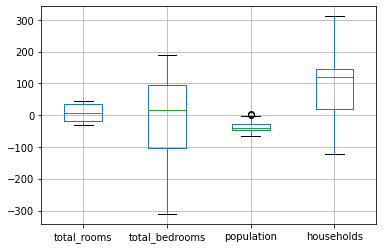

In [41]:
df_coef[features[1:-1]].boxplot()

In [ ]:
# the wild fluctuation in coefficients per feature proves the features are dependent.
# the boxplot shows the impact of feature dependence on our ability to interpret a linear
# model.
# we will do feature engineering to produce a set of six independent features from the
# given feature set.
# specifically, we'll use Principal Component Analysis (PCA)
# PCA assumed the variables are jointly normally distributed.
